In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, auc, precision_recall_curve, roc_curve
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from statistics import mean 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
import pickle

In [2]:
df = pd.read_csv("../dataset.csv", 
                  usecols=None,
                  low_memory=False, 
                  dtype=str
                )

#### VIN, Metered Time and Meter ID columns can be dropped because of their low frequency

In [3]:
df = df.drop(columns=["VIN", "Marked Time", "Meter Id"])

### Kept 20% of of training dataset untouched for final testing of the model

In [4]:
# Keep 20% of training data for final test
train_org = df[~df["Make"].isna()]
train_org = train_org.sample(frac=1, random_state=22)
final_test = train_org.sample(frac = 0.2, random_state=22) 
train_org = train_org[~train_org["Ticket number"].isin(final_test["Ticket number"])]
no_label_test = df[df["Make"].isna()]

In [5]:
print("Training dataset: ", train_org["Ticket number"].nunique())
print("Final test dataset : ", final_test["Ticket number"].nunique())
print("No label dataset: ", no_label_test["Ticket number"].nunique())

Training dataset:  3486035
Final test dataset :  871509
No label dataset:  4368470


## Data Preprocessing

 ###   1. Convert Target Class to Binary

In [6]:
# 1: Top25 , 0:uncommon make
def create_label(col,common_makes):
    if col in common_makes:
        return 1
    else:
        return 0

In [7]:
label_freq = pd.DataFrame({"make":train_org["Make"].value_counts().index, 
                           "freq":train_org["Make"].value_counts().values
                          })
label_freq = label_freq.sort_values("freq", ascending=False)

top_25 = label_freq[:25]
common_makes = list(top_25["make"].unique())

train_org.loc[:,"target"] = train_org["Make"].apply(lambda x: create_label(x, common_makes))

# Remove redundunt columns
train_org = train_org.drop(columns=["Violation Description", "Location", "Make"])

In [8]:
print("Data is unbalanced toward lable 1")
print(train_org["target"].value_counts())

Data is unbalanced toward lable 1
1    3188614
0     297421
Name: target, dtype: int64


### 2. One-Hot encoding categorical features

In [9]:
train = train_org.drop(columns=['Route', 'Violation code', 'RP State Plate', "Issue Date", 
                                'Agency', 'Issue time', 'Latitude', 'Longitude'])

categorical_columns = ['Color', 'Body Style']
numerical_columns = ['Fine amount', 'Plate Expiry Date']

train = pd.get_dummies(data=train, columns=categorical_columns)

train = train.fillna(0)
train = train.sample(frac=1)

### 3. Standardized (scaled) features, feature selection and fitting the model workflow

In [74]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scaler = MinMaxScaler()
clf = LogisticRegression(class_weight = {0: len(train)/len(train["target"]==0), 
                                         1: len(train)/len(train["target"]==1)}, max_iter = 10000)

x = train.drop(columns=["Ticket number", "target"])
y = train[["target"]]
param_candidate = [{'skb__k':list(range(1,20))}, 
                   {'estimator__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 10, 100, 1000]}] #


avg_scores = []

pipeline = Pipeline([('scalar', scaler), ('skb', SelectKBest(chi2)), ('estimator', clf)]) 
scores = []

for train_ix, test_ix in kfold.split(train, y):

    test_X = x.iloc[test_ix]
    test_y = y.iloc[test_ix].values

    train_X = x.iloc[train_ix]
    train_y = y.iloc[train_ix].values

    clf = GridSearchCV(pipeline, param_grid=param_candidate, cv=2,scoring="roc_auc", verbose=1)
    clf = clf.fit(train_X, train_y.ravel())
    
    features=list(train_X.columns[clf.best_estimator_.named_steps.skb.get_support()])
    print(features)

    print('Best score for data:', clf.best_score_) 
    print('Best C:',clf.best_params_) 

    predicts = clf.predict_proba(test_X)[:,1]
    fpr, tpr, thresholds = roc_curve(test_y, predicts, pos_label=1)
    auc_scoure = auc(fpr, tpr)

    scores.append(auc_scoure)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
['Plate Expiry Date', 'Color_BG', 'Color_BN', 'Color_GY', 'Color_SL', 'Color_TA', 'Color_WH', 'Color_YE', 'Body Style_BU', 'Body Style_CM', 'Body Style_MC', 'Body Style_MH', 'Body Style_MS', 'Body Style_PA', 'Body Style_PU', 'Body Style_RV', 'Body Style_TK', 'Body Style_TL', 'Body Style_TR']
Best score for data: 0.6537623068834484
Best C: {'skb__k': 19}
Fitting 2 folds for each of 27 candidates, totalling 54 fits
['Plate Expiry Date', 'Color_BG', 'Color_BN', 'Color_GY', 'Color_SL', 'Color_TA', 'Color_WH', 'Color_YE', 'Body Style_BU', 'Body Style_CM', 'Body Style_MC', 'Body Style_MH', 'Body Style_MS', 'Body Style_PA', 'Body Style_PU', 'Body Style_RV', 'Body Style_TK', 'Body Style_TL', 'Body Style_TR']
Best score for data: 0.6531215026656075
Best C: {'skb__k': 19}
Fitting 2 folds for each of 27 candidates, totalling 54 fits
['Plate Expiry Date', 'Color_BG', 'Color_BN', 'Color_GY', 'Color_SL', 'Color_TA', 'Color_WH', 'Color_YE',

#### Based on this feature selection we are going to drop  'Latitude', 'Longitude'  columns. They don't look like important features. If I had more time I would probably explore clustering the lat/long to convert them to categories using geolocations
#### Also based on data analysis it makes sense to drop 'Agency' and 'Issue time'.

### Funtions for the model server

In [12]:
def build_labels(train_set):
    
    train_org = train_set[~train_set["Make"].isna()]
    train_org = train_org.sample(frac=1, random_state=22)
    
    label_freq = pd.DataFrame({"make":train_org["Make"].value_counts().index, 
                           "freq":train_org["Make"].value_counts().values
                              })
    
    label_freq = label_freq.sort_values("freq", ascending=False)

    top_25 = label_freq[:25]
    common_makes = list(top_25["make"].unique())

    train_org.loc[:,"target"] = train_org["Make"].apply(lambda x: create_label(x, common_makes))
    train_org = train_org.drop(columns = "Make")
    
    return train_org
    

In [63]:
def preprocess_data(df, categorical_columns = ['Color', 'Body Style']):
    
    df = df[~df["Make"].isna()]

    df = df.drop(columns=["VIN", "Marked Time", "Meter Id", "Issue Date", 
                          "Violation Description", "Location", 'Route', 
                          'Violation code', 'RP State Plate', "Issue Date", 'Latitude', 'Longitude', 
                          'Agency', 'Issue time'])
    
    train = pd.get_dummies(data=df, columns=categorical_columns)

    train = train.fillna(0)
    train = train.sample(frac=1)
    
    return train

In [14]:
def train_model(train_dataset):
    
    scaler = MinMaxScaler()
    clf = LogisticRegression(class_weight = {0: len(train)/len(train["target"]==0), 
                                             1: len(train)/len(train["target"]==1)}, max_iter = 10000)

    pipeline = Pipeline([('scalar', scaler), ('skb', SelectKBest(chi2)), ('estimator', clf)]) 

    x = train_dataset.drop(columns=["Ticket number", "target"])
    y = train_dataset[["target"]].values

    param_candidate = [{'estimator__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 10, 100]}, 
                       {'skb__k':list(range(1,20))}]

    clf = GridSearchCV(pipeline, param_grid=param_candidate, cv=2,scoring="roc_auc", verbose=1)
    clf = clf.fit(x, y.ravel())

    print('Best score for data:', clf.best_score_) 
    print('Best params:',clf.best_params_) 
        
    
    return clf

### Train and fit with training data and test on 20% data

In [65]:
df = pd.read_csv("../dataset.csv", 
                  usecols=None,
                  low_memory=False, 
                  dtype=str
                )

#### prepocess data

In [66]:
df_dataset = preprocess_data(df)

In [67]:
# Keep 20% of training data for final test
train_org = df_dataset[~df_dataset["Make"].isna()]
train_org = build_labels(train_org)

In [68]:
train_org = train_org.sample(frac=1, random_state=22)
final_test = train_org.sample(frac = 0.2, random_state=22) 
train_org = train_org[~train_org["Ticket number"].isin(final_test["Ticket number"])]

##### Train Model

In [ ]:
#Run Pre Trained Model:
model_details = pickle.load(open("../clf_features_pretraind.pkl","rb"))
clf = model_details[0]
features = list(model_details[1])

#Train A Model
# clf = train_model(train_org, use_pre_trained = False)

#### Preprocess Test Set

In [72]:
X_test = final_test.drop(columns=["Ticket number", "target"])
Y_test = final_test[["target"]].values

In [73]:
final_test["target"].value_counts()

1    796855
0     74654
Name: target, dtype: int64

##### Run on test set

In [74]:
predicts = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, predicts, pos_label=1)
auc_scoure = auc(fpr, tpr)

##### Model evaluation

#### The baseline AUC was 0.56. Using feature selection and fine tuning we improved the model to 0.65
#### The dataset is very unbalanced. This is probably why using AUC is better than presion and recall.

In [75]:
auc_scoure

0.6536407686381056

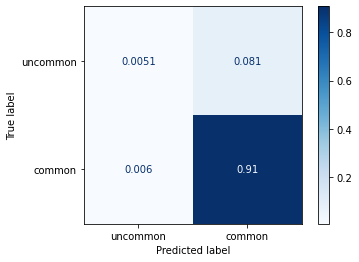

In [76]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test, Y_test,
                                 display_labels=["uncommon", "common"],
                                 cmap=plt.cm.Blues,
                                 normalize='all')

#### The model is very generous in predicting label 1 (common make).  Possible next steps could be:
    1. Trying training model with balanced data instead of startified kfold 
    2. Adding roc curve in cross validation for each fold to understand model's behaviour better

In [77]:
from sklearn.metrics import plot_roc_curve, plot_roc_curve

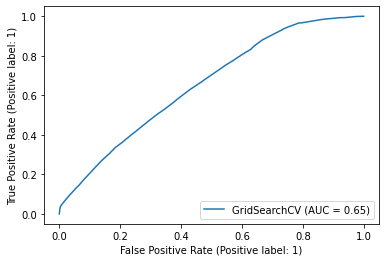

In [78]:
plot_roc_curve(clf, X_test, Y_test, pos_label=1) 

In [79]:
from sklearn.metrics import classification_report
threshold = 0.6
preds_label = np.where(predicts>threshold, 1, 0)
print(classification_report(Y_test, preds_label))

              precision    recall  f1-score   support

           0       0.50      0.08      0.14     74654
           1       0.92      0.99      0.95    796855

    accuracy                           0.91    871509
   macro avg       0.71      0.54      0.55    871509
weighted avg       0.88      0.91      0.89    871509

